## Reading/exploring WZ data

In [33]:
import numpy as np
import matplotlib.pyplot as pl
import pickle as pkl
import mcz
import os
import jax
import jax.numpy as jnp
import h5py
from scipy.interpolate import interp1d
from scipy.optimize import minimize

#import pyccl as ccl

datadir = "./data/"

useTz = False    # Set True to use triangular z bins instead of Qlna

## TO DO:
* need constant term in Legendre of sys function when using more than one spec survey since b_u freedom is not enough sys offset for 2 spec surveys?

Done:

* check some f_um derivatives
* Implement basis functions over r for alpha_r
* Evaluate w models and compare to data
* return MAP values of marginalized parameters
* Combine multiple reference surveys 
* Rectangular, triangular kernels


## Boyan's samples

In [13]:
# Boyan's file gives 3sDir samples of n(z).
# 'zbins' array are the bin edges = 0.01 + np.arange(81)*0.05
# 'zbinsc' are the centers = 0.035 + np.arange(80) * 0.05
# 'bins[0-3]' are the samples themselves, each 1M x 80
pz = h5py.File(os.path.join('./combined_nz_samples_y6_RU_ZPU_LHC_fullZ_1e4_sum1_stdRUmethod_Aug26.h5'))
pzsamp = jnp.stack( [jnp.array(pz['bin{:d}'.format(i)]) for i in range(4)], axis = 0)
zzz = np.array(pz['zbins'])
# Make triangular kernel set
pzK = mcz.Tz(zzz[1]-zzz[0], len(zzz)-1, startz=zzz[0])
# Free memory
del pz
pzsamp = pzsamp[:,:1000,:]  # Just for now

Text(0, 0.5, 'dn/dz')

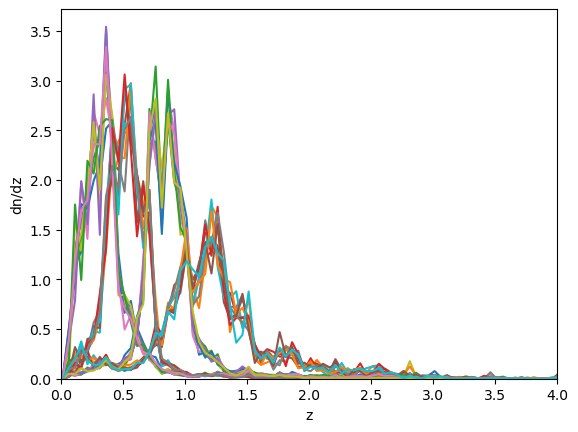

In [14]:
# Plot first 10 samples
# Get kernel functions
zz = np.arange(0,4.01,0.01)
nzk = np.stack( [pzK(i,zz) for i in range(pzK.nz)], axis=1)
# Contract with coefficients
nz = np.einsum('zk,uik->iuz',nzk,pzsamp)
# Plot
for i in range(10):
    for u in range(4):
        pl.plot(zz,nz[i,u])
pl.xlim(0,4)
pl.ylim(0,pl.ylim()[1])
pl.xlabel('z')
pl.ylabel('dn/dz')


## Fiducial cosmology results

In [15]:
# Read the file of cosmological functions produced earlier for fiducial
# cosmology by `wdm` script
tmp = np.load(open(os.path.join(datadir,'ccl_wdm.npz'),'rb'))

wdm = interp1d(tmp['z'], tmp['wdm'], kind='cubic',bounds_error=False, fill_value=(tmp['wdm'][0],tmp['wdm'][-1]))
c_over_H = interp1d(tmp['z'], tmp['c_over_H'], kind='cubic',bounds_error=False, 
                    fill_value=(tmp['c_over_H'][0],tmp['c_over_H'][-1]))
x = np.concatenate( (np.array([0.,]),tmp['z']))
y = np.concatenate( (np.array([0.,]),tmp['cda']))
cda = interp1d(x,y, kind='cubic',bounds_error=False, fill_value=(y[0],y[-1]))

## Read William's WZ data and other parameters

In [16]:
bossdata = pkl.load(open(os.path.join(datadir,'Metadetect_BOSS_WZ_28august.pickle'), 'rb'))
for k,v in bossdata.items():
    print(k,len(v))

z Boss WZ 26
w_ur Boss bin1--4 4
Cov w_ur Boss for indiv bins (with Hartlap) 4
Full-Cov noisy w_ur BOSS(with Hartlap) 104
Full-Cov clean w_ur BOSS 104
br Boss 26
Err on br  26
alpha_boss [mu,sigma] 2
alpha_meta [mu,sigma] 2
Order pol max sys 4
Sys [s_uk]_k 4
z for SOMPZ nz 300
n(z) from SOMPZ 4
z for wdm 116
wdm_NL  116


In [24]:
# Data using BOSS as reference 
zr = bossdata['z Boss WZ']
zr0 = zr[0]
dzr = zr[1]-zr[0]
Nr = len(zr)

boss = {}

boss['z_r'] = np.array(zr)  # Save z_r values for plotting purposes

# Correlation data:
boss['w'] = jnp.array(bossdata['w_ur Boss bin1--4'])
Nu = boss['w'].shape[0]
print('BOSS Nr:',Nr, 'w shape:',boss['w'].shape)
cov_w = np.array(bossdata['Full-Cov noisy w_ur BOSS(with Hartlap)'])
# Reshape the dense covariance matrix
boss['Sw'] = mcz.prep_cov_w_dense(cov_w,Nu,Nr)
print('Sw shape:',boss['Sw'].shape)
      
# Assign a nominal bias to each u
b_u = jnp.ones( Nu, dtype=float) * 1.1

# And unkowns' magnification priors
alpha0, sig = bossdata['alpha_meta [mu,sigma]']
boss['alpha_u0'] = jnp.ones(Nu, dtype=float) * alpha0
boss['sigma_alpha_u'] = jnp.ones(Nu, dtype=float) * sig  

# Collect reference info
boss['b_r']= jnp.array(bossdata['br Boss'])

# Read the sigmas on the Sys coefficients. 
sig = np.array(bossdata['Sys [s_uk]_k'])
# !!! Set the constant terms' sigma to smaller value since
# largely degenerate with bias
sig[:,0] = 0.1
# Also set sigmas to a positive minimum to avoid possible ugliness
# with sigma=0
sig = np.maximum(sig,0.001)
boss['sigma_s_uk'] = jnp.array(sig)
Nk = boss['sigma_s_uk'].shape[1]

boss['Sys_kr'] = mcz.sys_basis(zr0,dzr,Nr,Nk)

# Make alpha_r a single value
boss['alpha_r_basis'] = jnp.ones((Nr,1), dtype=float)
alpha0, sig = bossdata['alpha_boss [mu,sigma]']
boss['ar0'] = jnp.array([alpha0,])
boss['sigma_ar'] = jnp.array([sig])

print('Nk:',Nk,'sys priors:',boss['sigma_s_uk'])

## Do the cosmological integrals for its bins
A, Mu, Mr = mcz.prep_wz_integrals(pzK,
                                  zr0, dzr, Nr,
                                  cda, c_over_H, wdm)
boss['A_mr'] = A
boss['Mu_mr'] = Mu
boss['Mr_mr'] = Mr

zr_boss = zr

BOSS Nr: 26 w shape: (4, 26)
Sw shape: (4, 4, 26, 26)
Nk: 5 sys priors: [[0.1   0.1   0.05  0.05  0.001]
 [0.1   0.1   0.1   0.05  0.001]
 [0.1   0.1   0.05  0.05  0.001]
 [0.1   0.1   0.05  0.05  0.001]]


In [25]:
bossdata['Sys [s_uk]_k']

[[0.5, 0.1, 0.05, 0.05, 0],
 [0.5, 0.1, 0.1, 0.05, 0],
 [0.5, 0.1, 0.05, 0.05, 0],
 [0.5, 0.1, 0.05, 0.05, 0]]

In [26]:
# Now read RM data
rmdata = pkl.load(open(os.path.join(datadir,'Metadetect_RM_WZ_28august.pickle'), 'rb'))
for k,v in rmdata.items():
    print(k,len(v))
    

z RM WZ 37
w_ur RM bin1--4 4
Cov w_ur RM for indiv bins (with Hartlap) 4
Full-Cov w_ur RM(with Hartlap) 148
br  37
Err on br (underestimated) 37
z array for RM n(z) 52
RM n(z) from BOSS WZ 37
alpha_red [mu,sigma] 2
alpha_meta [mu,sigma] 2
Order pol max sys 4
Sys [s_uk]_k 4
z for SOMPZ nz 300
n(z) from SOMPZ 4
z for wdm 116
wdm_NL  116


In [27]:
# Data using RedMagic as reference 

rm = {}
# Redmagic differs because each reference bin is a sum over other bins, with this 
# matrix:
rmnz = jnp.array(rmdata['RM n(z) from BOSS WZ'])
# summing over these "original" bins:
rmz = rmdata['z array for RM n(z)']
rmnz = rmnz / np.sum(rmnz, axis=1)[:,np.newaxis]
zr0 = rmz[0]
dzr = rmz[1]-rmz[0]
Nr = len(rmz)

rm['z_r'] = np.array(rmz)  # Save z_r values for plotting purposes

# Do the cosmological integrals in the original bins
A, Mu, Mr = mcz.prep_wz_integrals(pzK,
                                  zr0, dzr, Nr,
                                  cda, c_over_H, wdm)
# Then average them over the n(z)'s of the RM bins
rm['A_mr'] = jnp.einsum('mr,sr->ms',A, rmnz)
rm['Mu_mr'] = jnp.einsum('mr,sr->ms',Mu, rmnz)
rm['Mr_mr'] = jnp.einsum('mr,sr->ms',Mr, rmnz)

# Now assign nominal z's to the RM bins:
zr = rmdata['z RM WZ']
zr0 = zr[0]
dzr = zr[1]-zr[0]
Nr = len(zr)

# Correlation data:
rm['w'] = jnp.array(rmdata['w_ur RM bin1--4'])

cov_w = np.array(rmdata['Full-Cov w_ur RM(with Hartlap)'])
rm['Sw'] = mcz.prep_cov_w_dense(cov_w,Nu,Nr)

# And unkowns' magnification priors
alpha0, sig = rmdata['alpha_meta [mu,sigma]']
rm['alpha_u0'] = jnp.ones(Nu, dtype=float) * alpha0
rm['sigma_alpha_u'] = jnp.ones(Nu, dtype=float) * sig  

# Collect reference info
rm['b_r']= jnp.array(rmdata['br '])

# Read the sigmas on the Sys coefficients. 
sig = np.array(rmdata['Sys [s_uk]_k'])
# Set sigmas to a positive minimum to avoid possible ugliness
# with sigma=0
sig = np.maximum(sig,0.001)
rm['sigma_s_uk'] = jnp.array(sig)
Nk = rm['sigma_s_uk'].shape[1]

rm['Sys_kr'] = mcz.sys_basis(zr0,dzr,Nr,Nk)

# Make alpha_r a single value
rm['alpha_r_basis'] = jnp.ones((Nr,1), dtype=float)
alpha0, sig = rmdata['alpha_red [mu,sigma]']
rm['ar0'] = jnp.array([alpha0,])
rm['sigma_ar'] = jnp.array([sig])

zr_rm = zr

In [28]:
allSpec = mcz.concatenate_surveys(boss,rm)

## Likelihood calculation

In [29]:
b_u = np.ones(Nu)*1.1
logp, qmap, derivs = mcz.logpwz_dense(f_um=pzsamp[:,0,:], b_u=b_u, **allSpec,
               return_qmap=True, return_derivs=True)

In [31]:
logp, qmap

(Array(-430.4812, dtype=float32),
 [Array([[-1.4646035e-01, -8.9111350e-02,  6.7830451e-02,  2.8659562e-02,
          -5.3445743e-05, -4.4101337e-01, -2.1950033e-01,  2.9736733e-02,
           7.3319219e-02,  3.8545307e-02],
         [-2.5728991e-02, -3.5537120e-02, -9.6026257e-02,  2.3622712e-02,
           3.8489688e-05, -3.1930944e-01, -1.8315953e-01, -1.9882593e-01,
          -1.0090027e-01,  1.9774236e-01],
         [ 1.3461260e-01,  1.5470162e-02, -4.3168373e-02, -1.7628288e-02,
           1.2460249e-05,  3.4749046e-02,  6.2420059e-02,  6.3962705e-02,
          -9.7001985e-02, -8.3325569e-05],
         [ 1.2494772e-01,  1.3559201e-01,  2.6894281e-02, -5.1668491e-03,
          -1.2075452e-05, -2.6788220e-01,  2.5705895e-01, -4.6514090e-02,
           2.2434075e-01,  6.0800216e-05]], dtype=float32),
  Array([ 0.5352994,  2.4297924, -1.0192914, -1.380563 ], dtype=float32),
  Array([ 0.02218082, -0.10712683], dtype=float32)])

## Probability maximization over b_u

In [44]:
logpwz = jax.jit(mcz.logpwz_dense, static_argnames=['return_qmap','return_derivs'])

def optimize_bu(f_um, survey, b_u=np.ones(Nu) * 1.1):
    '''Find values of b_u that maximize the probability
    of the WZ data under the n(z) given by f_um.
    Arguments:
    `f_um`: Array of shape (Nu,Nm) specifying n(z)
    `survey`: Dictionary of WZ data/priors arguments
            needed by `mcz.logpwz` function
    `b_u`:  Starting values of bin biases.
    Returns:
    `logp`: Log of maximized probability
    `b_u`:  Maximizing bias values '''
    
    def func(b_u):
        '''Function to be minimized - return -log p and
        its gradient w.r.t. b_u'''
        logp, derivs = logpwz(f_um, jnp.array(b_u),
                               **allSpec,
                               return_derivs=True)
        return -logp, -derivs[1]

    out = minimize(func, b_u, jac=True, method='BFGS', options={'xrtol':0.01})
    return -out.fun, out.x

In [45]:
%%time
logp = []
bu = []
for i in range(100):
    out = optimize_bu(pzsamp[:,i,:], allSpec)
    logp.append(out[0])
    bu.append(out[1])
    if i%10==0:
        print('done',i)

done 0
done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35
done 36
done 37
done 38
done 39
done 40
done 41
done 42
done 43
done 44
done 45
done 46
done 47
done 48
done 49
done 50
done 51
done 52
done 53
done 54
done 55
done 56
done 57
done 58
done 59
done 60
done 61
done 62
done 63
done 64
done 65
done 66
done 67
done 68
done 69
done 70
done 71
done 72
done 73
done 74
done 75
done 76
done 77
done 78
done 79
done 80
done 81
done 82
done 83
done 84
done 85
done 86
done 87
done 88
done 89
done 90
done 91
done 92
done 93
done 94
done 95
done 96
done 97
done 98
done 99
CPU times: user 2min 32s, sys: 10min 55s, total: 13min 27s
Wall time: 58.9 s


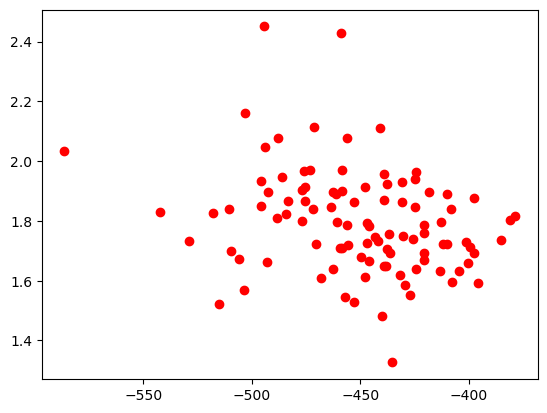

In [51]:
bu = np.array(bu)
pl.plot(logp, bu[:,3],'ro')

## Plot a case

In [ ]:
# Reconstruct the data
def plotWZ(f_um, b_u, survey):
    '''Make a plot of model vs data for WZ bins.'''
    logp, qmap = logpwz(jnp.array(f_um), jnp.array(bu_opt),
                           **survey,
                           return_qmap=True)
    wmod = mcz.w_model(f_um, b_u,  *qmap, **survey)

    pl.figure(figsize=(10,5))
    for u in range(4):
        c = pl.rcParams['axes.prop_cycle'].by_key()['color'][u]
        dw = survey['w'][u,:] - wmod[u,:]
        invcov = survey['Sw'][u].T @ survey['Sw'][u]
        chisq = dw.T @ invcov @ dw
        sig = 1 / np.sqrt(np.diag(invcov))
        pl.errorbar(zr_all,survey['w'][u,:],yerr=sig, marker='o',linestyle='None',
                   color=c, ms=5)
        pl.plot(zr_all,wmod[u,:], color=c, linestyle='-', label='Bin {:d} chisq {:.1f}/{:d}'.format(u+1, chisq, len(dw)-5) )
    pl.axhline(0, color='k', lw=2)
    pl.legend()
    pl.xlabel('Reference redshift')
    pl.ylabel('w_ur')
    pl.title('w_ur data vs best fit from SOMPZ')
    
    u=3
    dw = w_ur[u,:] - wmod[u,:]
    chisq = dw**2 / np.diag(cov_w[u])
    for z,chi in zip(zr, chisq):
        print('{:.2f} {:.1f}'.format(z,chi))
    print("Total:",np.sum(chisq), 'Full:',dw@np.linalg.inv(cov_w[u])@dw)

## Check some derivatives (old code)

In [ ]:
# Test gradient w.r.t. a component of b_u
x = []
y = []
dy = []
uu = 2
for bu in np.arange(0.8,3.21,0.1):
    b_u = jnp.ones( Nu, dtype=float) * 1.3
    b_u = b_u.at[uu].set(bu)
    logp, derivs = mcz.logpwz(f_um, b_u, 
                            alpha_u0, sigma_alpha_u, 
                            **survey,
                           return_derivs=True)
    x.append(bu)
    y.append(logp)
    dy.append(derivs[1][uu])
x = np.array(x)
y = np.array(y)
dy = np.array(dy)
dy_meas = np.zeros_like(dy)
dy_meas[1:-1] = (y[2:]-y[:-2]) / (x[2:]-x[:-2])
for a,b,c,d in zip(x,y,dy,dy_meas):
    print('{:.4f}'.format(a), b,c,d)

In [ ]:
# Check derivs w.r.t. some f_um
um=(3,10)
x = []
y = []
dy = []
for dfum in np.arange(-0.02,0.021,0.01):
    f_um_test = jnp.array(f_um)
    f_um_test = f_um_test.at[um].add(dfum)
    logp, derivs = mcz.logpwz(f_um_test, b_u,
           alpha_u0, sigma_alpha_u, 
           **survey,
           return_derivs=True)
    x.append(f_um_test[um])
    y.append(logp)
    dy.append(derivs[0][um])
x = np.array(x)
y = np.array(y)
dy = np.array(dy)
dy_meas = np.zeros_like(dy)
dy_meas[1:-1] = (y[2:]-y[:-2]) / (x[2:]-x[:-2])
for a,b,c,d in zip(x,y,dy,dy_meas):
    print('{:.4f}'.format(a), b,c,d)

## Test A/Mu/Mr with Gaussian bins to match William

In [ ]:

# Make r Gaussians out of narrow z rectangles

# Integrate clustering quantities between pairs of
# a kernel element and small rectangular reference bins

zr0 = 0.01    # CENTER of first reference bin
dzr = 0.01    # width of reference bins
Nzr = 150      # Number of reference bins
Omega_m = 0.315
oversamp_r = 2  # oversampling of z for reference bins

# Points at which to sample r functions
zr = np.linspace( zr0-dzr/2, zr0+(Nzr-0.5)*dzr, Nzr*oversamp_r+1)

def collapse_r(array, axis=0):
    '''Take oversampled function of zr and collapse back into Nzr bins'''
    # Move the zr axis to the front
    x = np.moveaxis(array,axis,0)
    # Start with endpoints for trapezoid integration
    out = 0.5*(x[:-1:oversamp_r] + x[oversamp_r::oversamp_r])
    # Add in middle points
    for i in range(1,oversamp_r):
        out += x[i::oversamp_r]
    # Include integration factor
    out *= 1. / oversamp_r
    # Move axis back
    if axis!=0:
        out = np.moveaxis(out,0,axis)
    return out

dzk = 0.005   # dz for integrating over kernels


Nk = 1


A = np.zeros( (Nk,Nzr), dtype=float)
Mu = np.zeros( (Nk,Nzr), dtype=float)
Mr = np.zeros( (Nk,Nzr), dtype=float)

cda_r = cda(zr)
H0H_r = c_over_H(zr) / c_over_H(0.)
a_r = 1 / (1+zr)
wdm_r = wdm(zr)
chi_r = cda(zr)
sigma = 0.1

for k in range(Nk):
    # First the clustering, evaluated at common set of z's
    kk = np.exp(-0.5*(zr-0.3)**2 / sigma**2) / np.sqrt(2*np.pi*sigma**2)
    A[k] = collapse_r(wdm_r * kk)

    # Now the lensing
    zmin = 0.
    zmax = 0.6
    n = 60
    zk = np.linspace(zmin,zmax,n+1)
    dz = zk[1]-zk[0]
    kk = np.exp(-0.5*(zk-0.3)**2 / sigma**2) / np.sqrt(2*np.pi*sigma**2)
    chi_u = cda(zk)
    # Calculate when the unknowns are the lensing sources
    # Mean lensing factor over the kernel:
    lens_u = dz * np.sum(np.maximum(0., 1 - chi_r[:,np.newaxis]/chi_u[np.newaxis,:])*kk, axis=-1)
    Mu[k] = collapse_r( lens_u * wdm_r * chi_r * (1+zr) * H0H_r)


    # When the references are the lensing sources:
    lens_r = np.maximum(0., 1 - chi_u[np.newaxis,:]/chi_r[:,np.newaxis]) # r is 1st index
    # Integrate over zk
    mm = dz * np.sum(kk*lens_r * wdm(zk) * chi_u * (1+zk) * (c_over_H(zk)/c_over_H(0.)), axis=1)
    # Integrate over zr:
    Mr[k] = collapse_r(mm)
    
Mu *= 3 * Omega_m / c_over_H(0.)
Mr *= 3 * Omega_m / c_over_H(0.)

    
# Add necessary b_r's
  

In [ ]:
A

In [ ]:
z0 = 0.3
zz = np.arange(Nzr)*dzr + zr0
kk = dzr*np.exp(-0.5*(zz-z0)**2 / sigma**2) / np.sqrt(2*np.pi*sigma**2)
np.sum(A[0]*kk)

In [ ]:
z0 = 0.9
zz = np.arange(Nzr)*dzr + zr0
kk = dzr * np.exp(-0.5*(zz-z0)**2 / sigma**2) / np.sqrt(2*np.pi*sigma**2)
np.sum(Mu[0]*kk), np.sum(Mr[0]*kk)

In [ ]:
william = pkl.load(open('William_30_July.pkl','rb'))
[k for k in william]

In [ ]:
zz = william['z list wdm and nz']
pl.plot(zz, william['wdm_NL (the one I use)'], label='William')
pl.plot(zz, wdm(zz), label='Gary')
pl.legend()
pl.grid()
pl.xlabel('z')
pl.ylabel('w_dm(z)')
pl.savefig('tmp.pdf')

## Scratch